# NFL Big Data Bowl 2026 - Comprehensive EDA
## Detailed Exploratory Data Analysis with Results Export

This notebook performs a complete analysis of the NFL player tracking data to understand:
- Data structure and quality
- Player movement patterns
- Ball trajectory characteristics
- Temporal patterns
- Feature distributions and correlations

All results are saved to `eda_results.json` for future reference.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import glob
import warnings
from pathlib import Path
from collections import defaultdict
from datetime import datetime

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Create output directories
Path('eda_outputs').mkdir(exist_ok=True)
Path('eda_outputs/plots').mkdir(exist_ok=True)

print("Libraries imported successfully!")
print(f"Analysis started at: {datetime.now()}")

Libraries imported successfully!
Analysis started at: 2025-11-10 16:20:58.201636


## 1. Data Loading

In [2]:
# Load all training data
input_files = sorted(glob.glob('train/input_2023_w*.csv'))
output_files = sorted(glob.glob('train/output_2023_w*.csv'))

print(f"Found {len(input_files)} input files")
print(f"Found {len(output_files)} output files")

# Load sample first to understand structure
print("\nLoading first week for initial inspection...")
sample_input = pd.read_csv(input_files[0])
sample_output = pd.read_csv(output_files[0])

print(f"\nSample input shape: {sample_input.shape}")
print(f"Sample output shape: {sample_output.shape}")

Found 18 input files
Found 18 output files

Loading first week for initial inspection...

Sample input shape: (285714, 23)
Sample output shape: (32088, 6)


In [3]:
# Load all data
print("Loading all training data...")
input_dfs = []
output_dfs = []

for i, (inp_file, out_file) in enumerate(zip(input_files, output_files), 1):
    print(f"Loading week {i:02d}...", end='\r')
    inp_df = pd.read_csv(inp_file)
    out_df = pd.read_csv(out_file)
    
    inp_df['week'] = i
    out_df['week'] = i
    
    input_dfs.append(inp_df)
    output_dfs.append(out_df)

df_input = pd.concat(input_dfs, ignore_index=True)
df_output = pd.concat(output_dfs, ignore_index=True)

print(f"\n\nTotal input records: {len(df_input):,}")
print(f"Total output records: {len(df_output):,}")
print(f"Memory usage - Input: {df_input.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Memory usage - Output: {df_output.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading all training data...
Loading week 18...

Total input records: 4,880,579
Total output records: 562,936
Memory usage - Input: 2722.20 MB
Memory usage - Output: 30.06 MB


## 2. Data Structure Analysis

In [4]:
# Initialize results dictionary
eda_results = {
    'metadata': {
        'analysis_date': str(datetime.now()),
        'total_weeks': len(input_files)
    },
    'data_structure': {},
    'data_quality': {},
    'feature_analysis': {},
    'play_characteristics': {},
    'player_analysis': {},
    'movement_patterns': {},
    'ball_trajectory': {},
    'correlations': {}
}

# Basic structure
eda_results['data_structure'] = {
    'input_shape': list(df_input.shape),
    'output_shape': list(df_output.shape),
    'input_columns': list(df_input.columns),
    'output_columns': list(df_output.columns),
    'input_dtypes': df_input.dtypes.astype(str).to_dict(),
    'output_dtypes': df_output.dtypes.astype(str).to_dict()
}

print("INPUT DATA COLUMNS:")
print(df_input.columns.tolist())
print("\nOUTPUT DATA COLUMNS:")
print(df_output.columns.tolist())

print("\n" + "="*80)
print("INPUT DATA INFO:")
print("="*80)
print(df_input.info())

print("\n" + "="*80)
print("OUTPUT DATA INFO:")
print("="*80)
print(df_output.info())

INPUT DATA COLUMNS:
['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'week']

OUTPUT DATA COLUMNS:
['game_id', 'play_id', 'nfl_id', 'frame_id', 'x', 'y', 'week']

INPUT DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880579 entries, 0 to 4880578
Data columns (total 24 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   game_id                   int64  
 1   play_id                   int64  
 2   player_to_predict         bool   
 3   nfl_id                    int64  
 4   frame_id                  int64  
 5   play_direction            object 
 6   absolute_yardline_number  int64  
 7   player_name               object 
 8   player_height             object 
 9   player_w

In [5]:
# Display sample data
print("SAMPLE INPUT DATA:")
display(df_input.head(10))

print("\nSAMPLE OUTPUT DATA:")
display(df_output.head(10))

SAMPLE INPUT DATA:


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,week
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22,1
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22,1
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22,1
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22,1
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22,1
5,2023090700,101,False,54527,6,right,42,Bryan Cook,6-1,210,...,52.44,36.88,0.60,0.87,106.89,247.67,21,63.259998,-0.22,1
6,2023090700,101,False,54527,7,right,42,Bryan Cook,6-1,210,...,52.51,36.86,0.76,0.64,103.87,247.67,21,63.259998,-0.22,1
7,2023090700,101,False,54527,8,right,42,Bryan Cook,6-1,210,...,52.60,36.85,0.91,0.92,100.97,246.69,21,63.259998,-0.22,1
8,2023090700,101,False,54527,9,right,42,Bryan Cook,6-1,210,...,52.71,36.83,1.10,1.31,98.15,247.39,21,63.259998,-0.22,1
9,2023090700,101,False,54527,10,right,42,Bryan Cook,6-1,210,...,52.84,36.81,1.32,1.71,96.73,243.01,21,63.259998,-0.22,1



SAMPLE OUTPUT DATA:


,game_id,play_id,nfl_id,frame_id,x,y,week
0,2023090700,101,46137,1,56.22,17.28,1
1,2023090700,101,46137,2,56.63,16.88,1
2,2023090700,101,46137,3,57.06,16.46,1
3,2023090700,101,46137,4,57.48,16.02,1
4,2023090700,101,46137,5,57.91,15.56,1
5,2023090700,101,46137,6,58.34,15.10,1
6,2023090700,101,46137,7,58.75,14.57,1
7,2023090700,101,46137,8,59.14,14.01,1
8,2023090700,101,46137,9,59.51,13.41,1
9,2023090700,101,46137,10,59.86,12.80,1


## 3. Data Quality Analysis

In [6]:
# Missing values
input_missing = df_input.isnull().sum()
output_missing = df_output.isnull().sum()

input_missing_pct = (input_missing / len(df_input) * 100).round(2)
output_missing_pct = (output_missing / len(df_output) * 100).round(2)

eda_results['data_quality']['input_missing_values'] = {
    col: {'count': int(input_missing[col]), 'percentage': float(input_missing_pct[col])}
    for col in df_input.columns if input_missing[col] > 0
}

eda_results['data_quality']['output_missing_values'] = {
    col: {'count': int(output_missing[col]), 'percentage': float(output_missing_pct[col])}
    for col in df_output.columns if output_missing[col] > 0
}

print("INPUT DATA - MISSING VALUES:")
print(input_missing[input_missing > 0])
print(f"\nPercentage:")
print(input_missing_pct[input_missing_pct > 0])

print("\n" + "="*80)
print("OUTPUT DATA - MISSING VALUES:")
print(output_missing[output_missing > 0])
print(f"\nPercentage:")
print(output_missing_pct[output_missing_pct > 0])

INPUT DATA - MISSING VALUES:
Series([], dtype: int64)

Percentage:
Series([], dtype: float64)

OUTPUT DATA - MISSING VALUES:
Series([], dtype: int64)

Percentage:
Series([], dtype: float64)


In [7]:
# Unique counts
unique_games = df_input['game_id'].nunique()
unique_plays = df_input.groupby('game_id')['play_id'].nunique().sum()
unique_players = df_input['nfl_id'].nunique()

eda_results['data_quality']['unique_counts'] = {
    'unique_games': int(unique_games),
    'unique_plays': int(unique_plays),
    'unique_players': int(unique_players),
    'total_play_instances': int(df_input.groupby(['game_id', 'play_id']).ngroups)
}

print(f"Unique games: {unique_games:,}")
print(f"Total unique plays: {unique_plays:,}")
print(f"Unique players: {unique_players:,}")
print(f"Unique game-play combinations: {df_input.groupby(['game_id', 'play_id']).ngroups:,}")

Unique games: 272
Total unique plays: 14,108
Unique players: 1,384
Unique game-play combinations: 14,108


## 4. Play Characteristics Analysis

PLAYERS PER PLAY:
count    14108.000000
mean        12.273178
std          1.118459
min          1.000000
25%         12.000000
50%         13.000000
75%         13.000000
max         17.000000
Name: nfl_id, dtype: float64


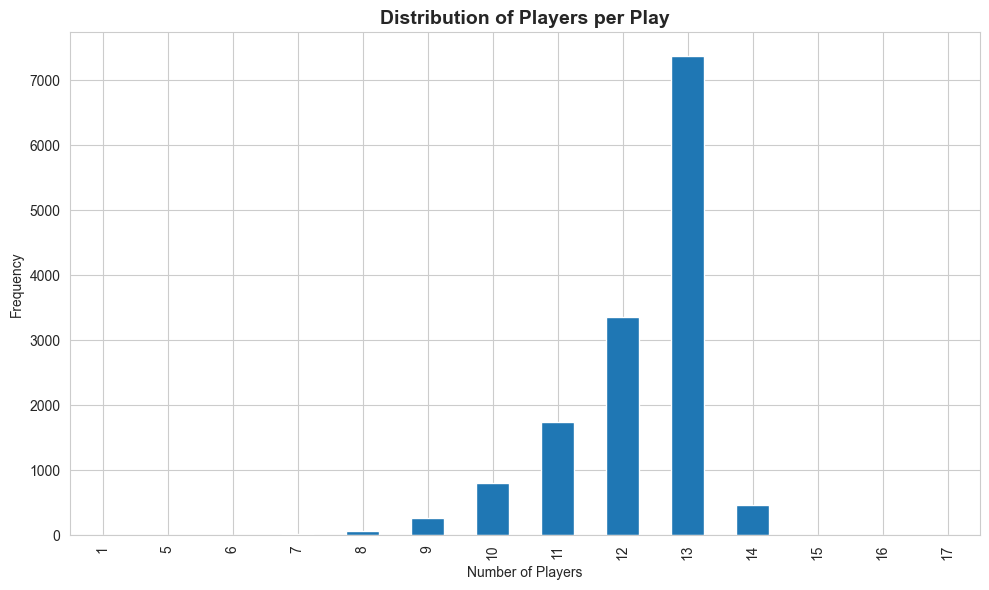

In [8]:
# Players per play
players_per_play = df_input.groupby(['game_id', 'play_id'])['nfl_id'].nunique()

eda_results['play_characteristics']['players_per_play'] = {
    'mean': float(players_per_play.mean()),
    'median': float(players_per_play.median()),
    'min': int(players_per_play.min()),
    'max': int(players_per_play.max()),
    'std': float(players_per_play.std())
}

print("PLAYERS PER PLAY:")
print(players_per_play.describe())

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
players_per_play.value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Distribution of Players per Play', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Players')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig('eda_outputs/plots/01_players_per_play.png', dpi=150, bbox_inches='tight')
plt.show()

INPUT FRAMES PER PLAY:
count    14108.000000
mean        28.133967
std          9.257372
min          8.000000
25%         22.000000
50%         26.000000
75%         32.000000
max        123.000000
Name: frame_id, dtype: float64


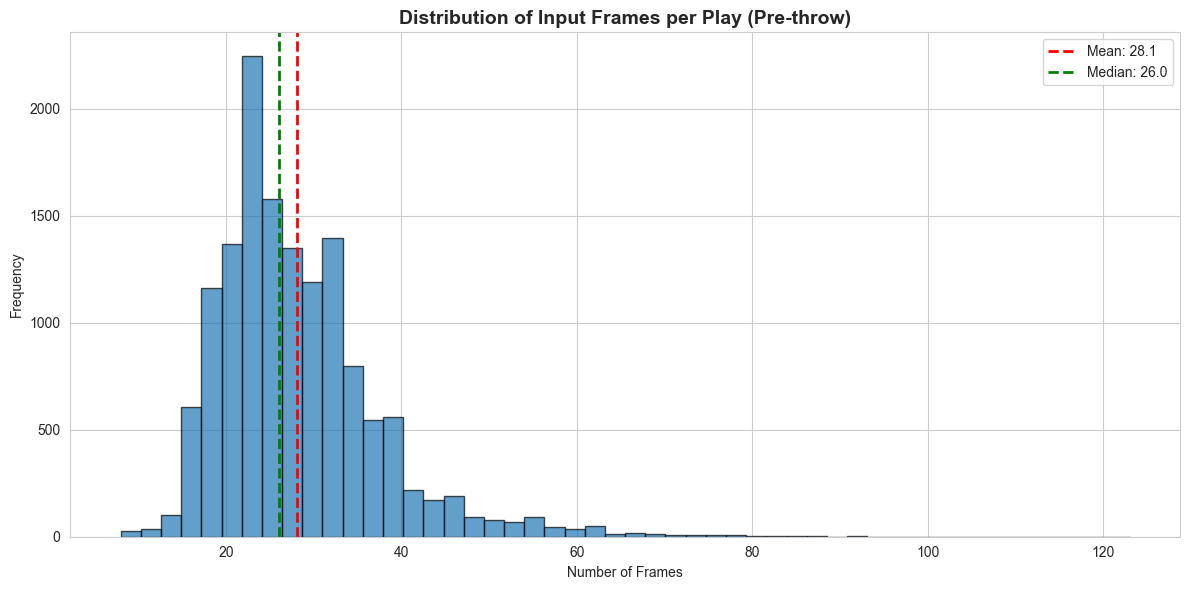

In [9]:
# Input frames per play
input_frames_per_play = df_input.groupby(['game_id', 'play_id'])['frame_id'].max()

eda_results['play_characteristics']['input_frames_per_play'] = {
    'mean': float(input_frames_per_play.mean()),
    'median': float(input_frames_per_play.median()),
    'min': int(input_frames_per_play.min()),
    'max': int(input_frames_per_play.max()),
    'std': float(input_frames_per_play.std())
}

print("INPUT FRAMES PER PLAY:")
print(input_frames_per_play.describe())

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(input_frames_per_play, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(input_frames_per_play.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {input_frames_per_play.mean():.1f}')
ax.axvline(input_frames_per_play.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {input_frames_per_play.median():.1f}')
ax.set_title('Distribution of Input Frames per Play (Pre-throw)', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Frames')
ax.set_ylabel('Frequency')
ax.legend()
plt.tight_layout()
plt.savefig('eda_outputs/plots/02_input_frames_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

OUTPUT FRAMES TO PREDICT (per player):
count    173150.000000
mean         11.294236
std           5.110444
min           5.000000
25%           8.000000
50%          10.000000
75%          13.000000
max          94.000000
Name: num_frames_output, dtype: float64

ACTUAL OUTPUT FRAMES (verification):
count    46045.000000
mean        12.225779
std          5.534126
min          5.000000
25%          8.000000
50%         11.000000
75%         14.000000
max         94.000000
Name: frame_id, dtype: float64


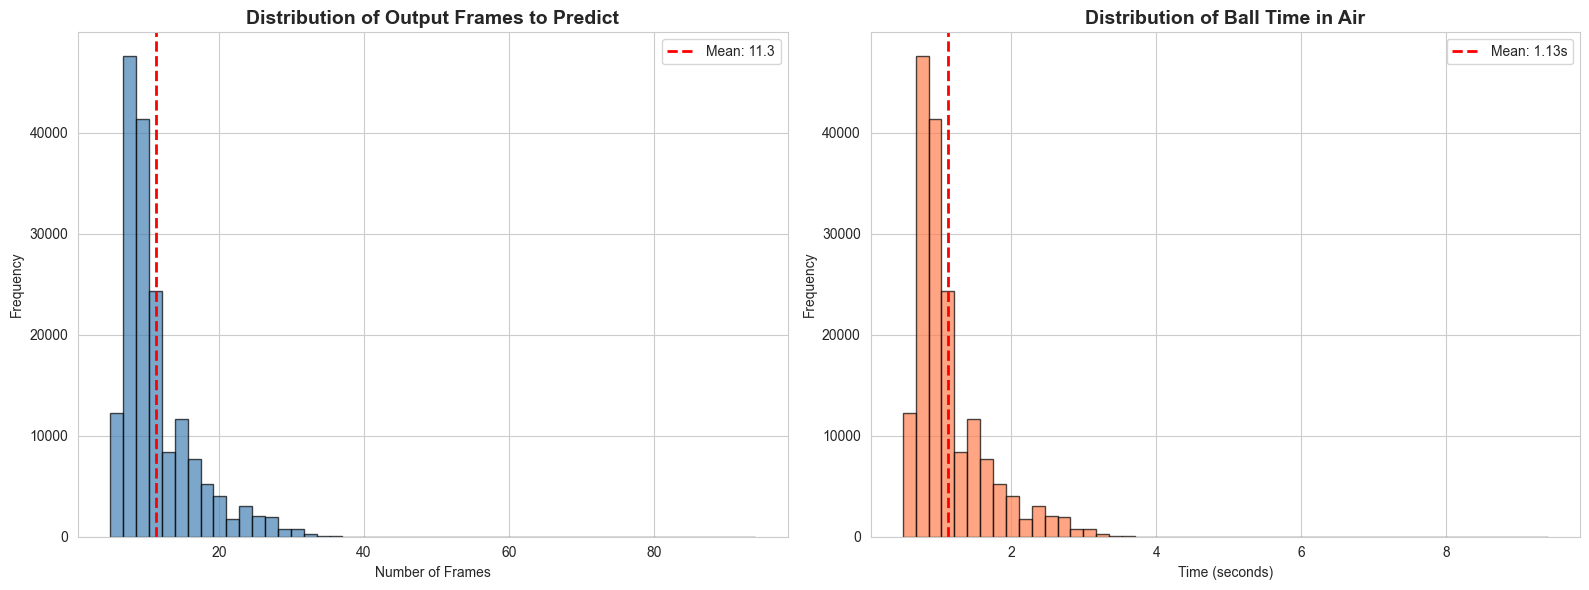

In [10]:
# Output frames to predict
output_frames = df_input.groupby(['game_id', 'play_id', 'nfl_id'])['num_frames_output'].first()

eda_results['play_characteristics']['output_frames_to_predict'] = {
    'mean': float(output_frames.mean()),
    'median': float(output_frames.median()),
    'min': int(output_frames.min()),
    'max': int(output_frames.max()),
    'std': float(output_frames.std())
}

print("OUTPUT FRAMES TO PREDICT (per player):")
print(output_frames.describe())

# Verify with actual output data
actual_output_frames = df_output.groupby(['game_id', 'play_id', 'nfl_id'])['frame_id'].max()
print("\nACTUAL OUTPUT FRAMES (verification):")
print(actual_output_frames.describe())

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(output_frames, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(output_frames.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {output_frames.mean():.1f}')
axes[0].set_title('Distribution of Output Frames to Predict', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Frames')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Time in air (frames * 0.1 seconds)
time_in_air = output_frames / 10  # Convert frames to seconds
axes[1].hist(time_in_air, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(time_in_air.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {time_in_air.mean():.2f}s')
axes[1].set_title('Distribution of Ball Time in Air', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.savefig('eda_outputs/plots/03_output_frames_and_time.png', dpi=150, bbox_inches='tight')
plt.show()

eda_results['play_characteristics']['ball_time_in_air_seconds'] = {
    'mean': float(time_in_air.mean()),
    'median': float(time_in_air.median()),
    'min': float(time_in_air.min()),
    'max': float(time_in_air.max()),
    'std': float(time_in_air.std())
}

In [11]:
# Play direction analysis
play_direction_counts = df_input.groupby(['game_id', 'play_id'])['play_direction'].first().value_counts()

eda_results['play_characteristics']['play_direction'] = {
    str(k): int(v) for k, v in play_direction_counts.items()
}

print("PLAY DIRECTION DISTRIBUTION:")
print(play_direction_counts)

# Yardline analysis
yardline_stats = df_input.groupby(['game_id', 'play_id'])['absolute_yardline_number'].first()

eda_results['play_characteristics']['absolute_yardline'] = {
    'mean': float(yardline_stats.mean()),
    'median': float(yardline_stats.median()),
    'min': float(yardline_stats.min()),
    'max': float(yardline_stats.max()),
    'std': float(yardline_stats.std())
}

print("\nABSOLUTE YARDLINE STATISTICS:")
print(yardline_stats.describe())

PLAY DIRECTION DISTRIBUTION:
play_direction
right    7117
left     6991
Name: count, dtype: int64

ABSOLUTE YARDLINE STATISTICS:
count    14108.000000
mean        60.498511
std         23.262021
min         11.000000
25%         41.000000
50%         61.000000
75%         80.000000
max        109.000000
Name: absolute_yardline_number, dtype: float64


## 5. Player Role Analysis

PLAYER POSITIONS:
player_position
WR     1063660
CB     1056888
FS      476865
TE      417146
QB      401007
SS      392421
RB      314918
ILB     295593
OLB     207429
MLB     199983
FB       19584
DE       16932
S        13764
DT        3139
NT        1090
T           83
LB          31
P           23
K           23
Name: count, dtype: int64

PLAYER SIDES:
player_side
Defense    2662657
Offense    2217922
Name: count, dtype: int64

PLAYER ROLES:
player_role
Defensive Coverage    2662657
Other Route Runner    1424243
Targeted Receiver      396914
Passer                 396765
Name: count, dtype: int64


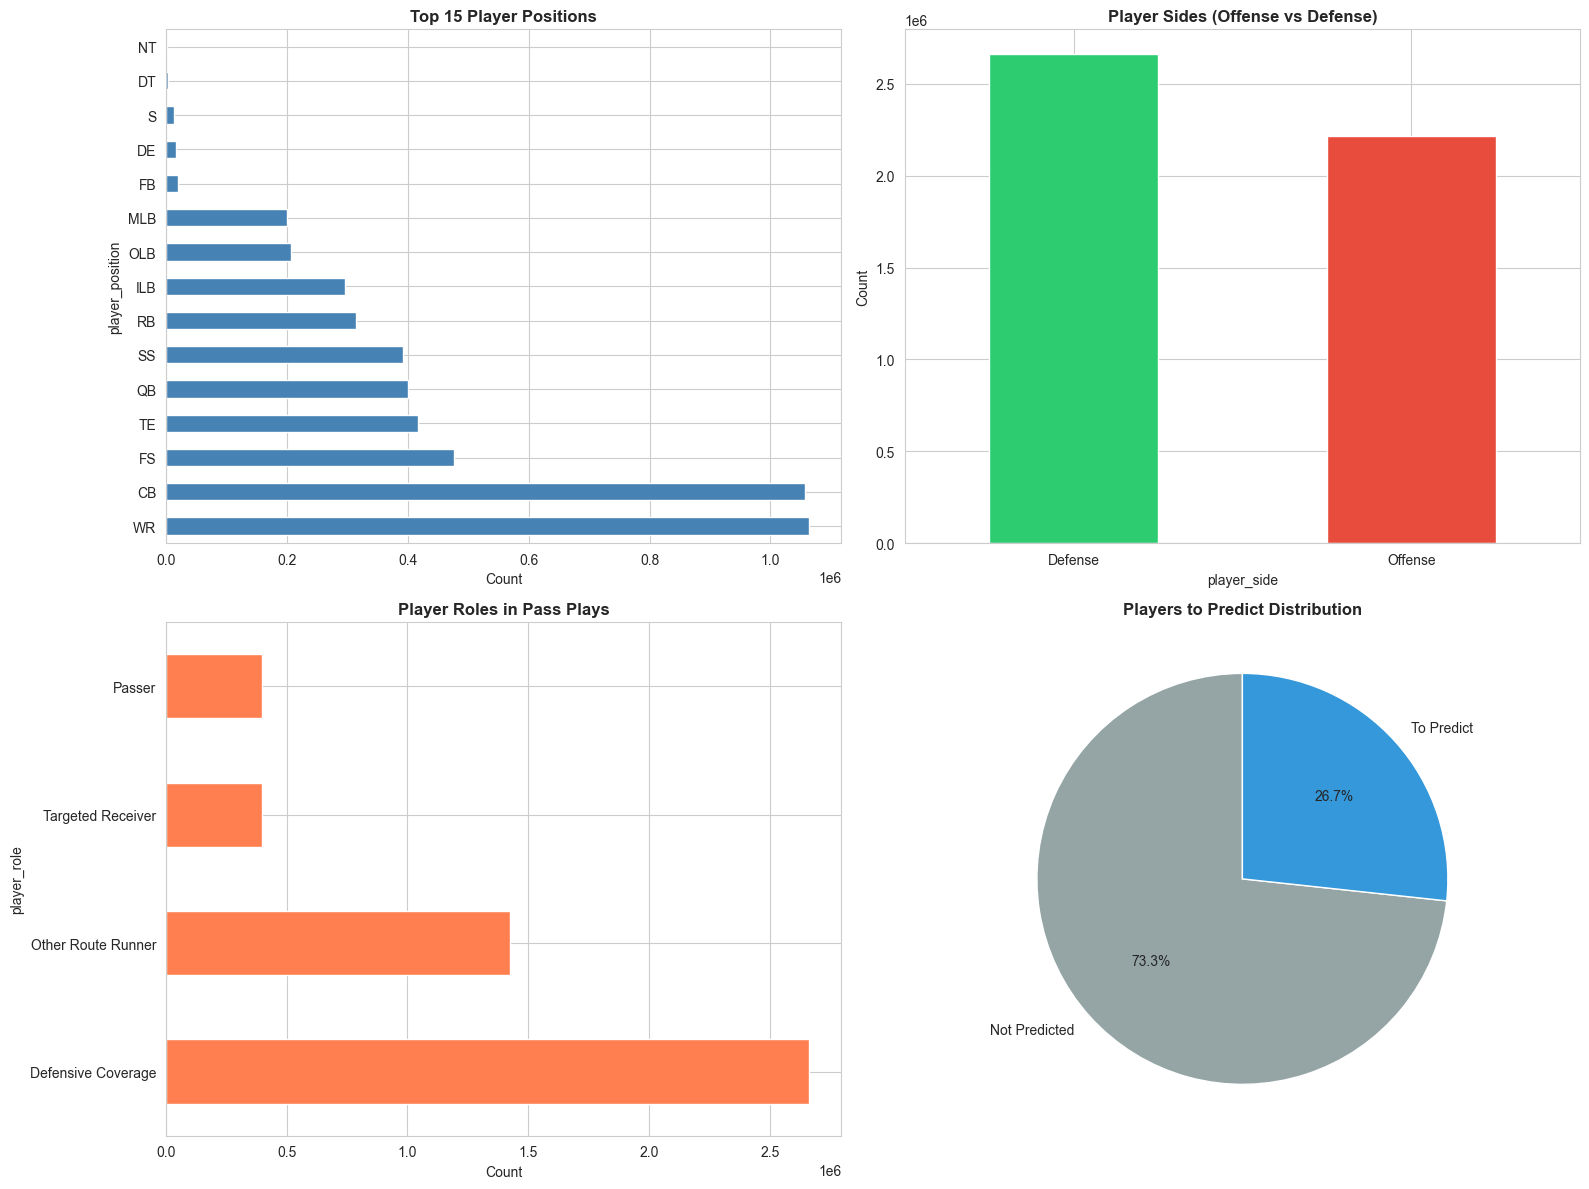

In [12]:
# Player positions
position_counts = df_input['player_position'].value_counts()
print("PLAYER POSITIONS:")
print(position_counts)

eda_results['player_analysis']['position_distribution'] = position_counts.to_dict()

# Player sides
side_counts = df_input['player_side'].value_counts()
print("\nPLAYER SIDES:")
print(side_counts)

eda_results['player_analysis']['side_distribution'] = side_counts.to_dict()

# Player roles
role_counts = df_input['player_role'].value_counts()
print("\nPLAYER ROLES:")
print(role_counts)

eda_results['player_analysis']['role_distribution'] = role_counts.to_dict()

# Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top positions
position_counts.head(15).plot(kind='barh', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Top 15 Player Positions', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Count')

# Player sides
side_counts.plot(kind='bar', ax=axes[0, 1], color=['#2ecc71', '#e74c3c'])
axes[0, 1].set_title('Player Sides (Offense vs Defense)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)

# Player roles
role_counts.plot(kind='barh', ax=axes[1, 0], color='coral')
axes[1, 0].set_title('Player Roles in Pass Plays', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Count')

# Players to predict
predict_counts = df_input['player_to_predict'].value_counts()
axes[1, 1].pie(predict_counts, labels=['Not Predicted', 'To Predict'], autopct='%1.1f%%', 
               colors=['#95a5a6', '#3498db'], startangle=90)
axes[1, 1].set_title('Players to Predict Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_outputs/plots/04_player_roles_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

eda_results['player_analysis']['players_to_predict'] = {
    'total_to_predict': int(df_input['player_to_predict'].sum()),
    'total_not_predict': int((~df_input['player_to_predict']).sum()),
    'percentage_to_predict': float(df_input['player_to_predict'].mean() * 100)
}

In [13]:
# Role by side analysis
role_side = pd.crosstab(df_input['player_role'], df_input['player_side'])
print("PLAYER ROLE BY SIDE:")
print(role_side)

eda_results['player_analysis']['role_by_side'] = role_side.to_dict()

PLAYER ROLE BY SIDE:
player_side         Defense  Offense
player_role                         
Defensive Coverage  2662657        0
Other Route Runner        0  1424243
Passer                    0   396765
Targeted Receiver         0   396914


## 6. Movement & Tracking Features Analysis

In [14]:
# Analyze position, speed, acceleration, orientation, direction
tracking_features = ['x', 'y', 's', 'a', 'o', 'dir']

print("TRACKING FEATURES STATISTICS (INPUT DATA):")
print("="*80)
stats_df = df_input[tracking_features].describe()
print(stats_df)

for feat in tracking_features:
    eda_results['feature_analysis'][f'{feat}_stats'] = {
        'mean': float(df_input[feat].mean()),
        'median': float(df_input[feat].median()),
        'std': float(df_input[feat].std()),
        'min': float(df_input[feat].min()),
        'max': float(df_input[feat].max()),
        'q25': float(df_input[feat].quantile(0.25)),
        'q75': float(df_input[feat].quantile(0.75))
    }

TRACKING FEATURES STATISTICS (INPUT DATA):
                  x             y             s             a             o  \
count  4.880579e+06  4.880579e+06  4.880579e+06  4.880579e+06  4.880579e+06   
mean   6.050074e+01  2.681190e+01  3.019878e+00  2.118335e+00  1.815366e+02   
std    2.348919e+01  1.000620e+01  2.227939e+00  1.415794e+00  9.800912e+01   
min    4.100000e-01  6.200000e-01  0.000000e+00  0.000000e+00  0.000000e+00   
25%    4.263000e+01  1.899000e+01  1.090000e+00  1.010000e+00  9.174000e+01   
50%    6.041000e+01  2.685000e+01  2.720000e+00  1.920000e+00  1.801400e+02   
75%    7.823000e+01  3.462000e+01  4.620000e+00  3.040000e+00  2.715800e+02   
max    1.198600e+02  5.288000e+01  1.253000e+01  1.712000e+01  3.600000e+02   

                dir  
count  4.880579e+06  
mean   1.804972e+02  
std    1.007162e+02  
min    0.000000e+00  
25%    9.091000e+01  
50%    1.795600e+02  
75%    2.708300e+02  
max    3.600000e+02  


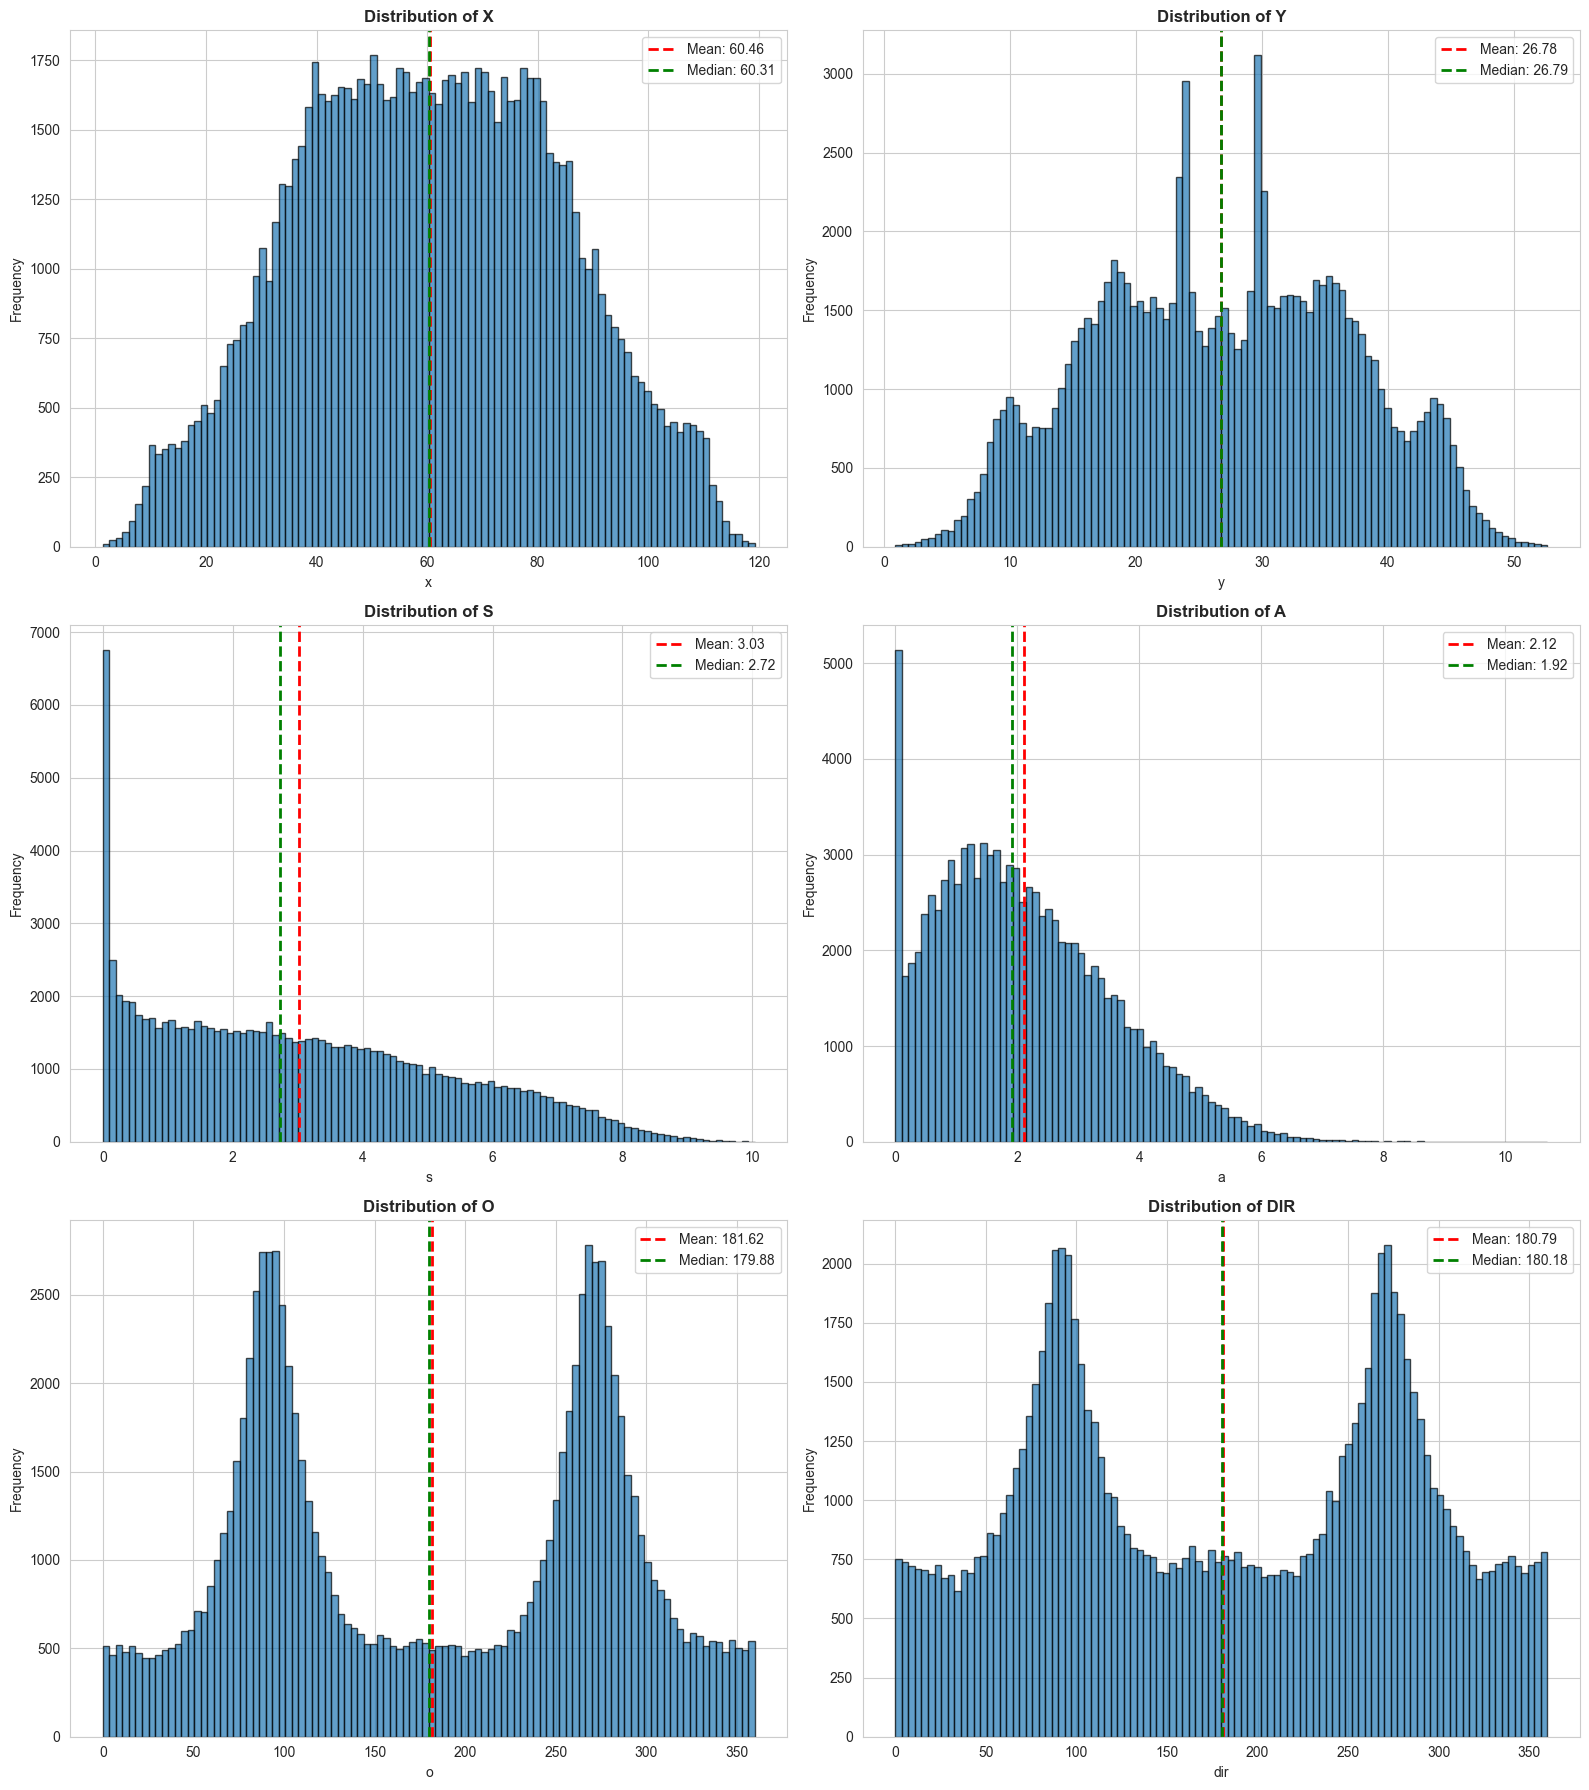

In [15]:
# Plot distributions
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for idx, feat in enumerate(tracking_features):
    # Sample data for faster plotting
    sample_data = df_input[feat].dropna().sample(min(100000, len(df_input)), random_state=42)
    
    axes[idx].hist(sample_data, bins=100, edgecolor='black', alpha=0.7)
    axes[idx].axvline(sample_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {sample_data.mean():.2f}')
    axes[idx].axvline(sample_data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {sample_data.median():.2f}')
    axes[idx].set_title(f'Distribution of {feat.upper()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(feat)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

plt.tight_layout()
plt.savefig('eda_outputs/plots/05_tracking_features_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

SPEED STATISTICS BY PLAYER ROLE:
                        count      mean       std  min   25%   50%   75%  \
player_role                                                                
Defensive Coverage  2662657.0  2.539118  1.845843  0.0  0.97  2.32  3.81   
Other Route Runner  1424243.0  3.987556  2.505436  0.0  1.78  4.19  6.09   
Passer               396765.0  1.800543  1.495855  0.0  0.65  1.54  2.53   
Targeted Receiver    396914.0  3.991578  2.465104  0.0  1.87  4.19  6.02   

                      max  
player_role                
Defensive Coverage  12.53  
Other Route Runner  10.33  
Passer               8.74  
Targeted Receiver   10.34  

ACCELERATION STATISTICS BY PLAYER ROLE:
                        count      mean       std  min   25%   50%   75%  \
player_role                                                                
Defensive Coverage  2662657.0  1.804227  1.268510  0.0  0.83  1.60  2.55   
Other Route Runner  1424243.0  2.598887  1.500035  0.0  1.44  2.54  3.67 

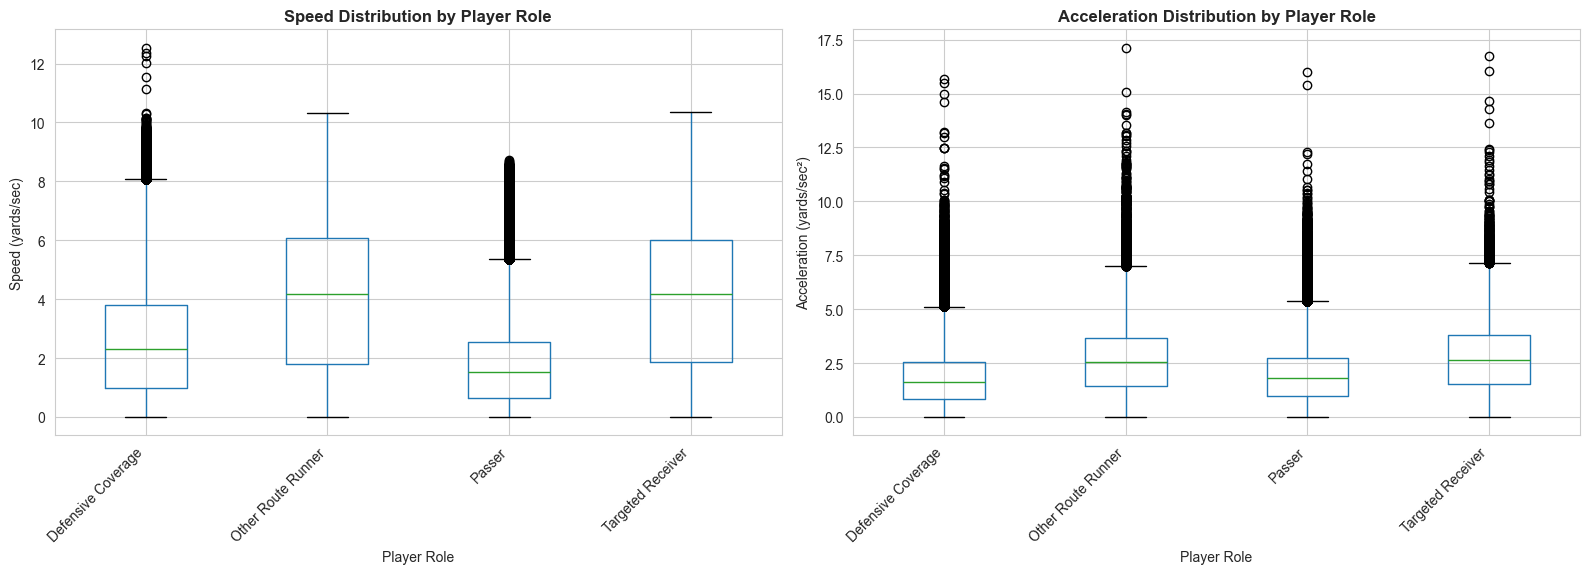

In [16]:
# Speed analysis by role
speed_by_role = df_input.groupby('player_role')['s'].describe()
print("SPEED STATISTICS BY PLAYER ROLE:")
print(speed_by_role)

eda_results['movement_patterns']['speed_by_role'] = speed_by_role.to_dict()

# Acceleration analysis by role
accel_by_role = df_input.groupby('player_role')['a'].describe()
print("\nACCELERATION STATISTICS BY PLAYER ROLE:")
print(accel_by_role)

eda_results['movement_patterns']['acceleration_by_role'] = accel_by_role.to_dict()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Speed by role
df_input.boxplot(column='s', by='player_role', ax=axes[0])
axes[0].set_title('Speed Distribution by Player Role', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Player Role')
axes[0].set_ylabel('Speed (yards/sec)')
axes[0].get_figure().suptitle('')  # Remove default title
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Acceleration by role
df_input.boxplot(column='a', by='player_role', ax=axes[1])
axes[1].set_title('Acceleration Distribution by Player Role', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Player Role')
axes[1].set_ylabel('Acceleration (yards/sec²)')
axes[1].get_figure().suptitle('')  # Remove default title
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('eda_outputs/plots/06_speed_accel_by_role.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Field Position Analysis

AttributeError: PathCollection.set() got an unexpected keyword argument 'zindex'

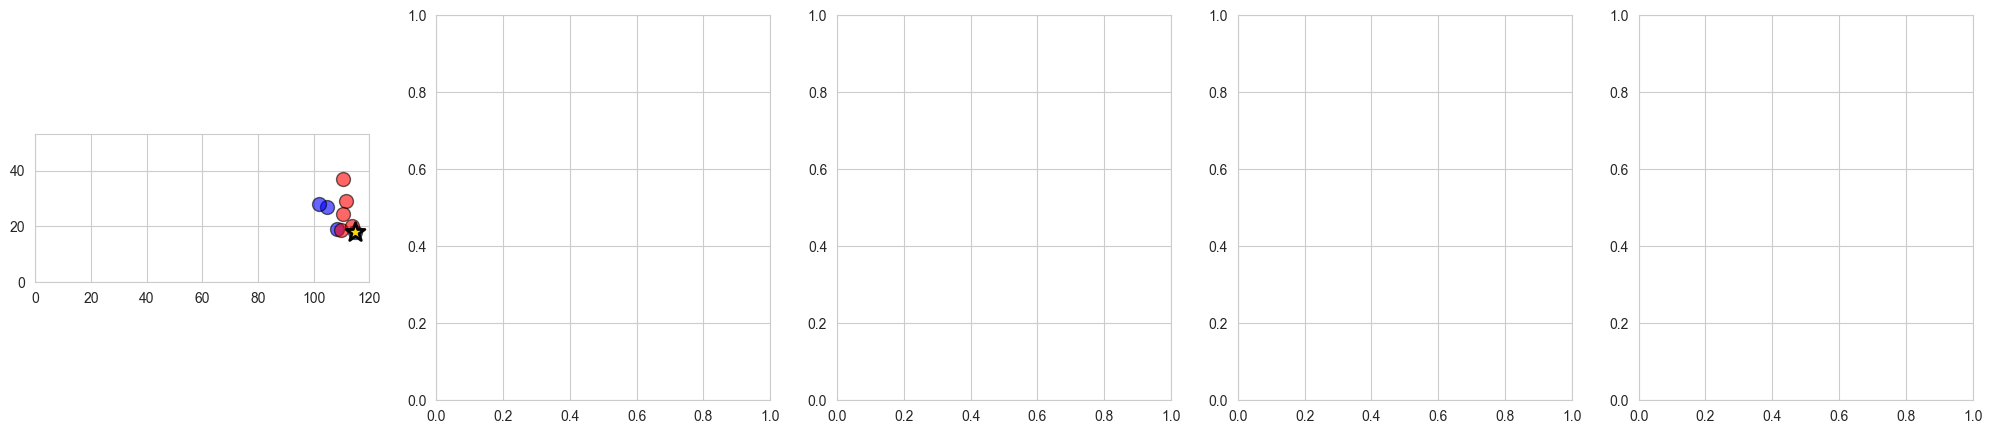

In [ ]:
# Sample a few plays for visualization
sample_plays = df_input.groupby(['game_id', 'play_id']).first().sample(5, random_state=42)

fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for idx, ((game_id, play_id), play_data) in enumerate(sample_plays.iterrows()):
    # Get all players for this play at last input frame
    play_input = df_input[(df_input['game_id'] == game_id) & (df_input['play_id'] == play_id)]
    last_frame = play_input['frame_id'].max()
    play_snapshot = play_input[play_input['frame_id'] == last_frame]
    
    # Plot field
    axes[idx].set_xlim(0, 120)
    axes[idx].set_ylim(0, 53.3)
    axes[idx].set_aspect('equal')
    
    # Plot players
    offense = play_snapshot[play_snapshot['player_side'] == 'Offense']
    defense = play_snapshot[play_snapshot['player_side'] == 'Defense']
    
    axes[idx].scatter(offense['x'], offense['y'], c='blue', s=100, alpha=0.6, label='Offense', edgecolors='black')
    axes[idx].scatter(defense['x'], defense['y'], c='red', s=100, alpha=0.6, label='Defense', edgecolors='black')
    
    # Highlight targeted receiver
    target = play_snapshot[play_snapshot['player_role'] == 'Targeted Receiver']
    if not target.empty:
        axes[idx].scatter(target['x'], target['y'], c='gold', s=200, marker='*', 
                         edgecolors='black', linewidths=2, label='Target', zorder=5)
    
    # Ball landing location
    ball_x = play_data['ball_land_x']
    ball_y = play_data['ball_land_y']
    axes[idx].scatter(ball_x, ball_y, c='green', s=300, marker='X', 
                     edgecolors='black', linewidths=2, label='Ball Land', zorder=6)
    
    axes[idx].set_title(f'Play {idx+1}\nGame: {game_id}, Play: {play_id}', fontsize=10)
    axes[idx].set_xlabel('X (yards)')
    if idx == 0:
        axes[idx].set_ylabel('Y (yards)')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend(loc='upper right', fontsize=8)

plt.suptitle('Sample Play Snapshots at Throw Time', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('eda_outputs/plots/07_sample_plays_field_position.png', dpi=150, bbox_inches='tight')
plt.show()

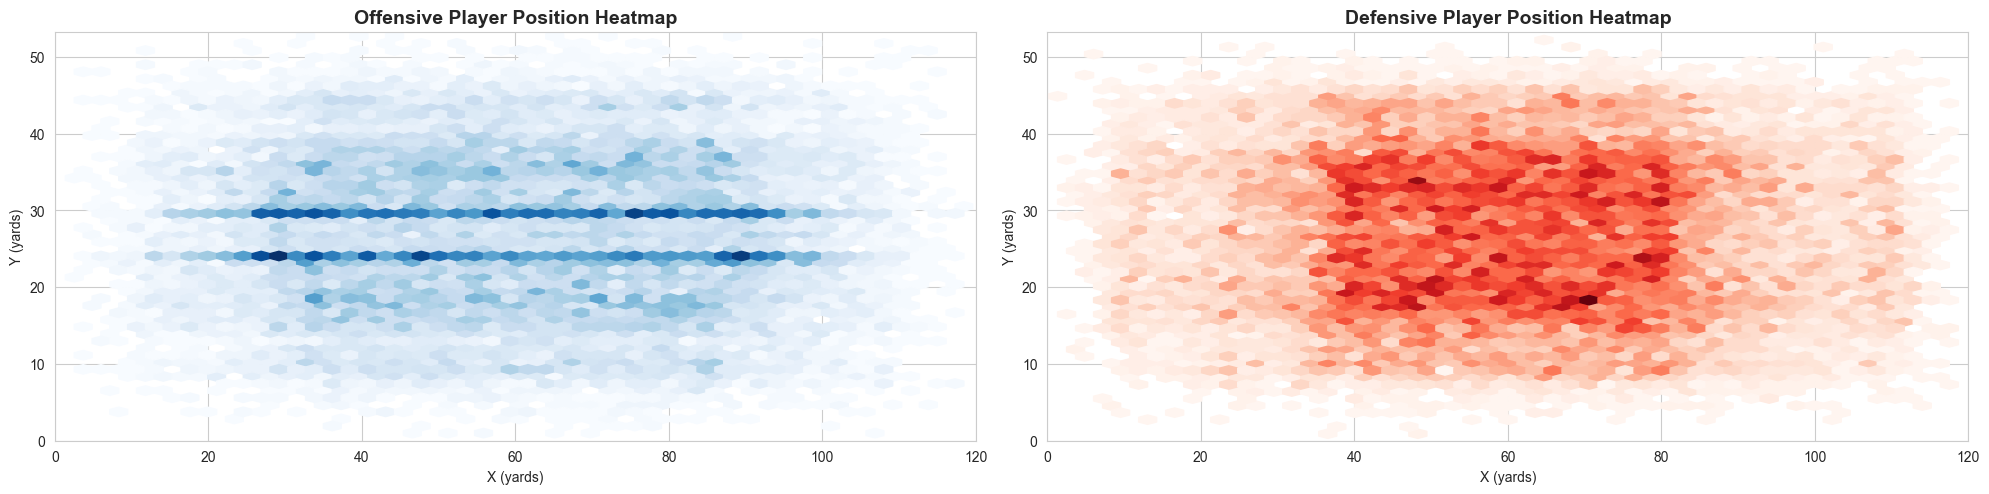

In [18]:
# Overall position heatmap
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Sample for faster plotting
sample_input = df_input.sample(min(50000, len(df_input)), random_state=42)

# Offense
offense_data = sample_input[sample_input['player_side'] == 'Offense']
axes[0].hexbin(offense_data['x'], offense_data['y'], gridsize=50, cmap='Blues', mincnt=1)
axes[0].set_xlim(0, 120)
axes[0].set_ylim(0, 53.3)
axes[0].set_title('Offensive Player Position Heatmap', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X (yards)')
axes[0].set_ylabel('Y (yards)')
axes[0].set_aspect('equal')

# Defense
defense_data = sample_input[sample_input['player_side'] == 'Defense']
axes[1].hexbin(defense_data['x'], defense_data['y'], gridsize=50, cmap='Reds', mincnt=1)
axes[1].set_xlim(0, 120)
axes[1].set_ylim(0, 53.3)
axes[1].set_title('Defensive Player Position Heatmap', fontsize=14, fontweight='bold')
axes[1].set_xlabel('X (yards)')
axes[1].set_ylabel('Y (yards)')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.savefig('eda_outputs/plots/08_position_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Ball Trajectory Analysis

In [19]:
# Get unique ball landing positions per play
ball_positions = df_input.groupby(['game_id', 'play_id'])[['ball_land_x', 'ball_land_y']].first()

print("BALL LANDING POSITION STATISTICS:")
print(ball_positions.describe())

eda_results['ball_trajectory']['ball_land_x'] = {
    'mean': float(ball_positions['ball_land_x'].mean()),
    'median': float(ball_positions['ball_land_x'].median()),
    'std': float(ball_positions['ball_land_x'].std()),
    'min': float(ball_positions['ball_land_x'].min()),
    'max': float(ball_positions['ball_land_x'].max())
}

eda_results['ball_trajectory']['ball_land_y'] = {
    'mean': float(ball_positions['ball_land_y'].mean()),
    'median': float(ball_positions['ball_land_y'].median()),
    'std': float(ball_positions['ball_land_y'].std()),
    'min': float(ball_positions['ball_land_y'].min()),
    'max': float(ball_positions['ball_land_y'].max())
}

BALL LANDING POSITION STATISTICS:
        ball_land_x   ball_land_y
count  14108.000000  14108.000000
mean      60.475035     26.635479
std       25.283144     15.259020
min       -5.260000     -3.910000
25%       42.397501     13.530000
50%       60.490002     26.480000
75%       78.550003     39.619999
max      125.849998     57.330002


PASS DISTANCE STATISTICS:
count    14108.000000
mean         9.051927
std          9.131363
min          0.000000
25%          2.750000
50%          5.589996
75%         12.799999
max         62.290001
Name: pass_distance, dtype: float64


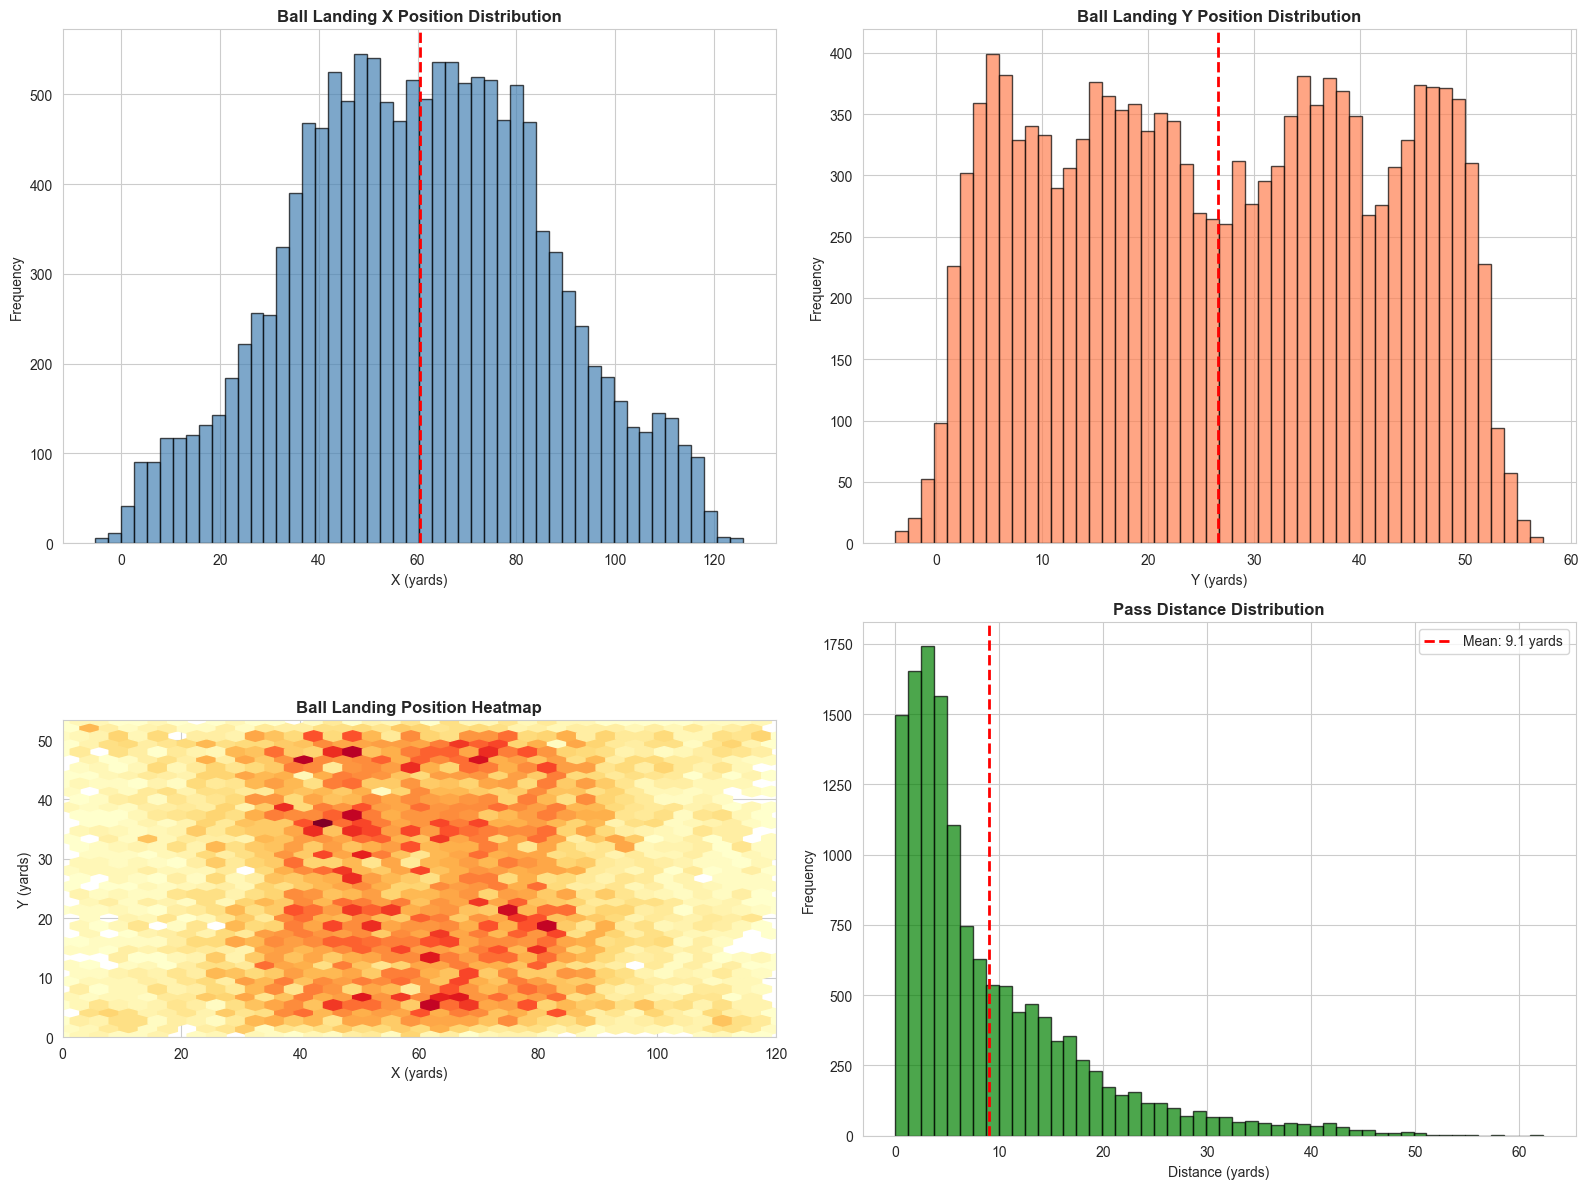

In [20]:
# Calculate pass distance (approximate from yardline to ball land)
play_info = df_input.groupby(['game_id', 'play_id']).first()
play_info['pass_distance'] = np.abs(play_info['ball_land_x'] - play_info['absolute_yardline_number'])

print("PASS DISTANCE STATISTICS:")
print(play_info['pass_distance'].describe())

eda_results['ball_trajectory']['pass_distance'] = {
    'mean': float(play_info['pass_distance'].mean()),
    'median': float(play_info['pass_distance'].median()),
    'std': float(play_info['pass_distance'].std()),
    'min': float(play_info['pass_distance'].min()),
    'max': float(play_info['pass_distance'].max())
}

# Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Ball landing X
axes[0, 0].hist(ball_positions['ball_land_x'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(ball_positions['ball_land_x'].mean(), color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Ball Landing X Position Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('X (yards)')
axes[0, 0].set_ylabel('Frequency')

# Ball landing Y
axes[0, 1].hist(ball_positions['ball_land_y'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].axvline(ball_positions['ball_land_y'].mean(), color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('Ball Landing Y Position Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Y (yards)')
axes[0, 1].set_ylabel('Frequency')

# 2D heatmap
axes[1, 0].hexbin(ball_positions['ball_land_x'], ball_positions['ball_land_y'], 
                  gridsize=40, cmap='YlOrRd', mincnt=1)
axes[1, 0].set_xlim(0, 120)
axes[1, 0].set_ylim(0, 53.3)
axes[1, 0].set_title('Ball Landing Position Heatmap', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('X (yards)')
axes[1, 0].set_ylabel('Y (yards)')
axes[1, 0].set_aspect('equal')

# Pass distance
axes[1, 1].hist(play_info['pass_distance'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].axvline(play_info['pass_distance'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {play_info["pass_distance"].mean():.1f} yards')
axes[1, 1].set_title('Pass Distance Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Distance (yards)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('eda_outputs/plots/09_ball_trajectory_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Movement Patterns - Input vs Output

In [21]:
# Compare input and output positions
# Get last input frame and first output frame for same players
last_input = df_input.groupby(['game_id', 'play_id', 'nfl_id']).last()[['x', 'y', 's', 'a']]
first_output = df_output.groupby(['game_id', 'play_id', 'nfl_id']).first()[['x', 'y']]

# Merge
transition = last_input.join(first_output, how='inner', rsuffix='_out')
transition['dx'] = transition['x_out'] - transition['x']
transition['dy'] = transition['y_out'] - transition['y']
transition['displacement'] = np.sqrt(transition['dx']**2 + transition['dy']**2)

print("MOVEMENT FROM LAST INPUT TO FIRST OUTPUT FRAME:")
print(transition[['dx', 'dy', 'displacement']].describe())

eda_results['movement_patterns']['input_to_output_transition'] = {
    'dx_mean': float(transition['dx'].mean()),
    'dx_std': float(transition['dx'].std()),
    'dy_mean': float(transition['dy'].mean()),
    'dy_std': float(transition['dy'].std()),
    'displacement_mean': float(transition['displacement'].mean()),
    'displacement_std': float(transition['displacement'].std())
}

# Note: 1 frame = 0.1 seconds
print(f"\nAverage displacement per frame: {transition['displacement'].mean():.3f} yards")
print(f"This corresponds to average speed: {transition['displacement'].mean() / 0.1:.3f} yards/sec")

MOVEMENT FROM LAST INPUT TO FIRST OUTPUT FRAME:
                 dx            dy  displacement
count  46045.000000  46045.000000  46045.000000
mean       0.002002     -0.004295      0.459409
std        0.343033      0.366428      0.202244
min       -1.040000     -1.010000      0.000000
25%       -0.230000     -0.280000      0.308707
50%        0.000000      0.000000      0.453100
75%        0.240000      0.270000      0.610328
max        1.010000      0.990000      1.043887

Average displacement per frame: 0.459 yards
This corresponds to average speed: 4.594 yards/sec



TOTAL MOVEMENT DURING OUTPUT SEQUENCE:
           total_dx      total_dy  total_displacement
count  46045.000000  46045.000000        46045.000000
mean       0.036316     -0.068370            5.838834
std        5.553551      5.060154            4.728673
min      -29.980000    -22.740000            0.010000
25%       -1.680000     -3.400000            2.692675
50%        0.030000     -0.070000            4.480681
75%        1.740000      3.260000            7.313905
max       30.240000     22.320000           32.485758


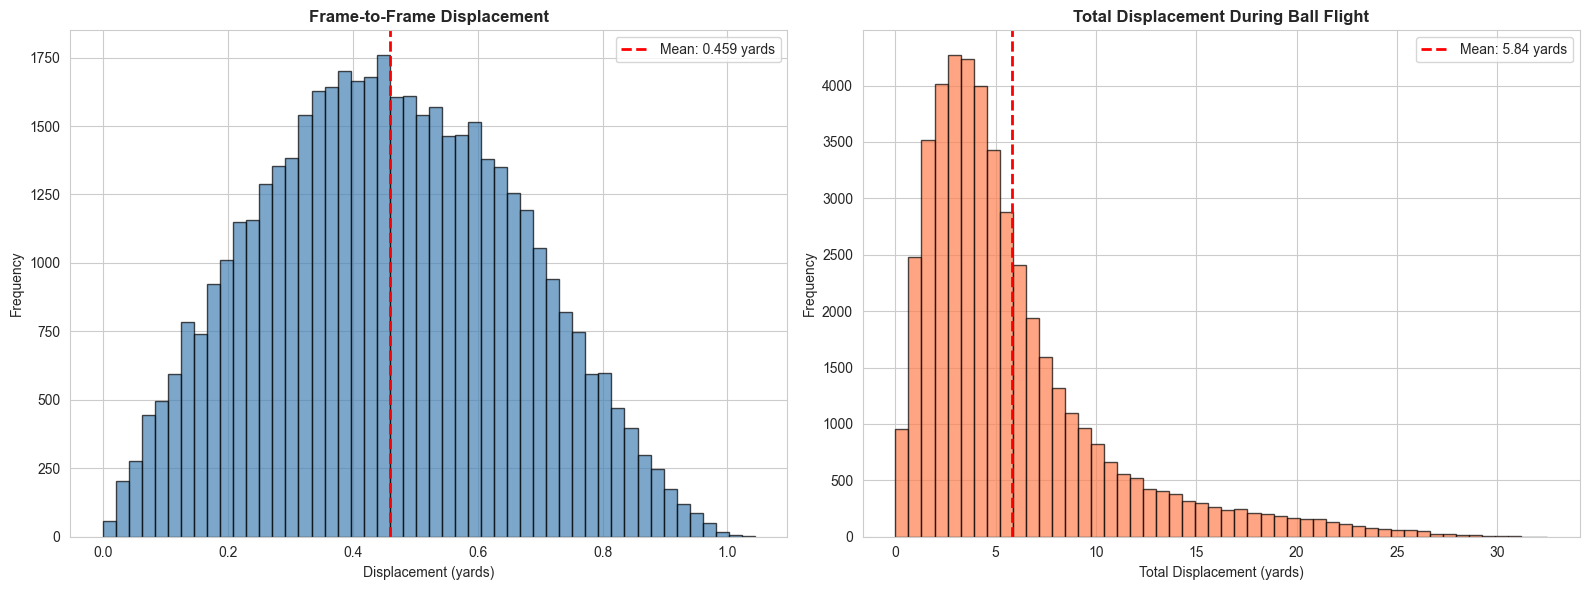

In [22]:
# Analyze total displacement in output sequences
output_first = df_output.groupby(['game_id', 'play_id', 'nfl_id']).first()[['x', 'y']]
output_last = df_output.groupby(['game_id', 'play_id', 'nfl_id']).last()[['x', 'y']]

total_movement = output_first.join(output_last, how='inner', rsuffix='_end')
total_movement['total_dx'] = total_movement['x_end'] - total_movement['x']
total_movement['total_dy'] = total_movement['y_end'] - total_movement['y']
total_movement['total_displacement'] = np.sqrt(total_movement['total_dx']**2 + total_movement['total_dy']**2)

print("\nTOTAL MOVEMENT DURING OUTPUT SEQUENCE:")
print(total_movement[['total_dx', 'total_dy', 'total_displacement']].describe())

eda_results['movement_patterns']['total_output_movement'] = {
    'total_dx_mean': float(total_movement['total_dx'].mean()),
    'total_dx_std': float(total_movement['total_dx'].std()),
    'total_dy_mean': float(total_movement['total_dy'].mean()),
    'total_dy_std': float(total_movement['total_dy'].std()),
    'total_displacement_mean': float(total_movement['total_displacement'].mean()),
    'total_displacement_std': float(total_movement['total_displacement'].std())
}

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Frame-to-frame displacement
axes[0].hist(transition['displacement'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(transition['displacement'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {transition["displacement"].mean():.3f} yards')
axes[0].set_title('Frame-to-Frame Displacement', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Displacement (yards)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Total displacement
axes[1].hist(total_movement['total_displacement'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(total_movement['total_displacement'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {total_movement["total_displacement"].mean():.2f} yards')
axes[1].set_title('Total Displacement During Ball Flight', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Total Displacement (yards)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.savefig('eda_outputs/plots/10_displacement_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Correlation Analysis

CORRELATION MATRIX:
                                 x         y         s         a         o  \
x                         1.000000 -0.008659  0.000567 -0.002196  0.135055   
y                        -0.008659  1.000000 -0.000502 -0.005224  0.010707   
s                         0.000567 -0.000502  1.000000  0.209881 -0.013791   
a                        -0.002196 -0.005224  0.209881  1.000000 -0.008320   
o                         0.135055  0.010707 -0.013791 -0.008320  1.000000   
dir                      -0.068831 -0.005683  0.005140 -0.003657 -0.020328   
absolute_yardline_number  0.937544 -0.007872  0.001988 -0.001310 -0.001153   
num_frames_output        -0.010061  0.005232  0.051017  0.011785 -0.002398   
ball_land_x               0.858944 -0.003384 -0.002377 -0.003205  0.029497   
ball_land_y              -0.007024  0.054235 -0.005773 -0.000848 -0.020387   

                               dir  absolute_yardline_number  \
x                        -0.068831                  0.937

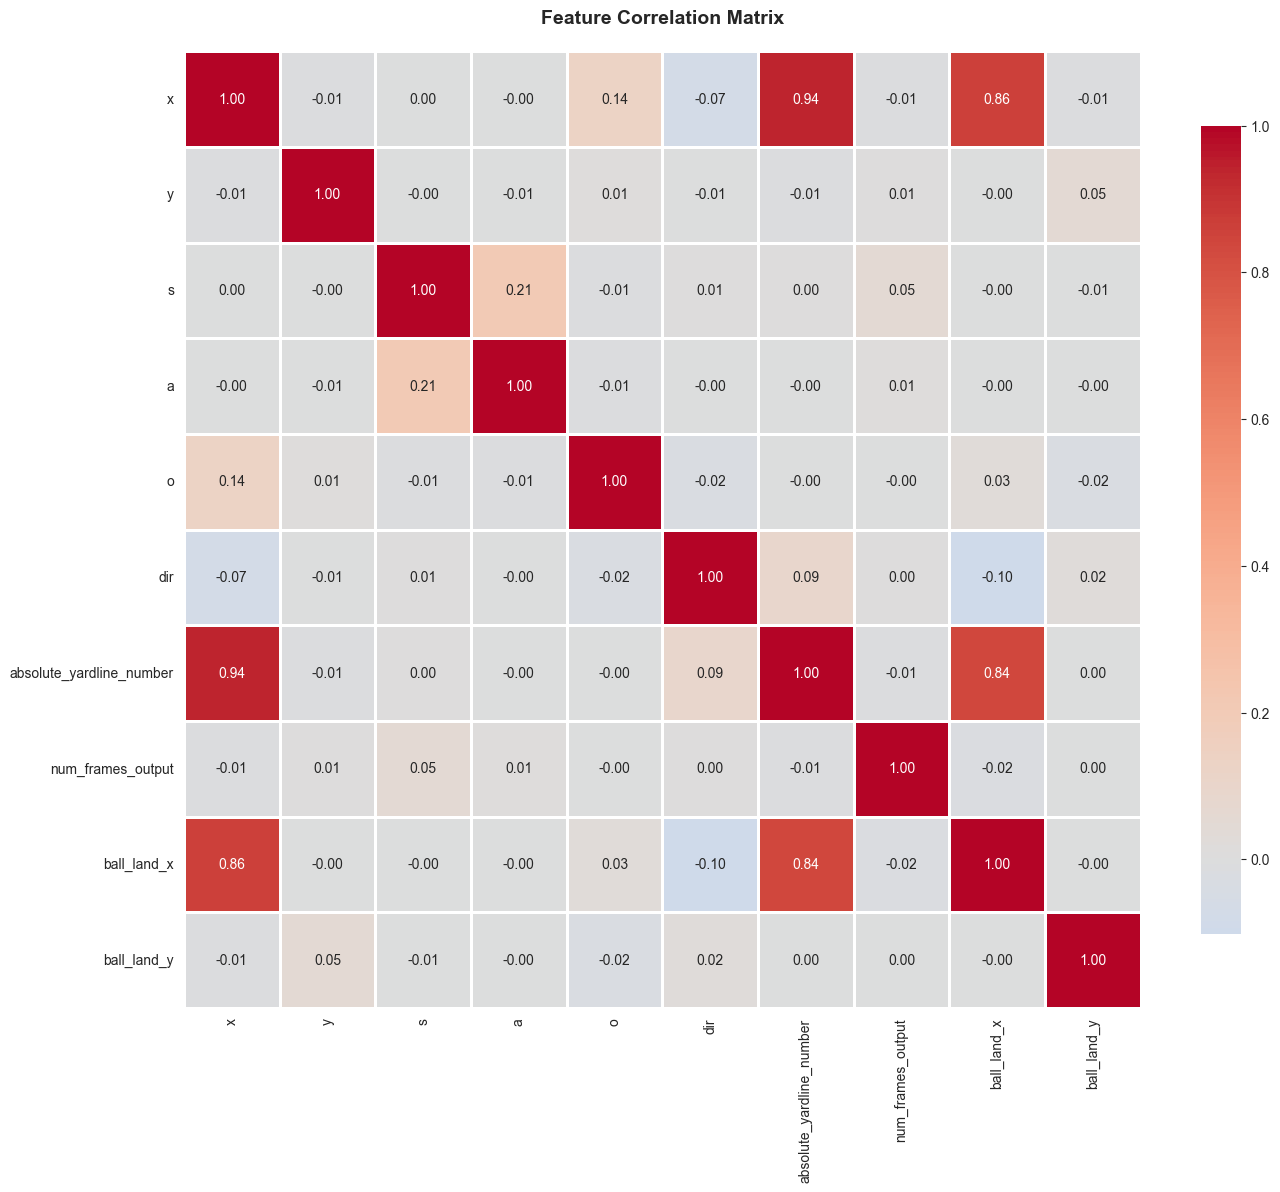

In [23]:
# Correlation matrix for numerical features
numerical_features = ['x', 'y', 's', 'a', 'o', 'dir', 'absolute_yardline_number', 
                     'num_frames_output', 'ball_land_x', 'ball_land_y']

# Sample for correlation calculation
sample_for_corr = df_input[numerical_features].dropna().sample(min(50000, len(df_input)), random_state=42)
corr_matrix = sample_for_corr.corr()

print("CORRELATION MATRIX:")
print(corr_matrix)

# Save to results
eda_results['correlations']['feature_correlation_matrix'] = corr_matrix.to_dict()

# Plot
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('eda_outputs/plots/11_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Temporal Patterns

WEEKLY STATISTICS:
      num_games  num_plays         s         a  num_frames_output
week                                                             
1            16        748  3.041966  2.126249          11.298669
2            16        777  2.931589  2.102854          11.227658
3            16        823  2.964380  2.112009          11.806211
4            16        710  3.026389  2.117546          11.411469
5            14        677  2.991852  2.099286          11.392815
6            15        715  2.998998  2.120898          11.318421
7            13        646  2.969080  2.099586          11.385103
8            16        765  3.021164  2.117436          11.769233
9            14        656  3.061792  2.135519          11.724932
10           14        673  3.058637  2.135039          11.703916
11           14        657  3.030971  2.110014          11.548681
12           16        755  3.048639  2.128390          11.289103
13           13        622  3.075218  2.121453          1

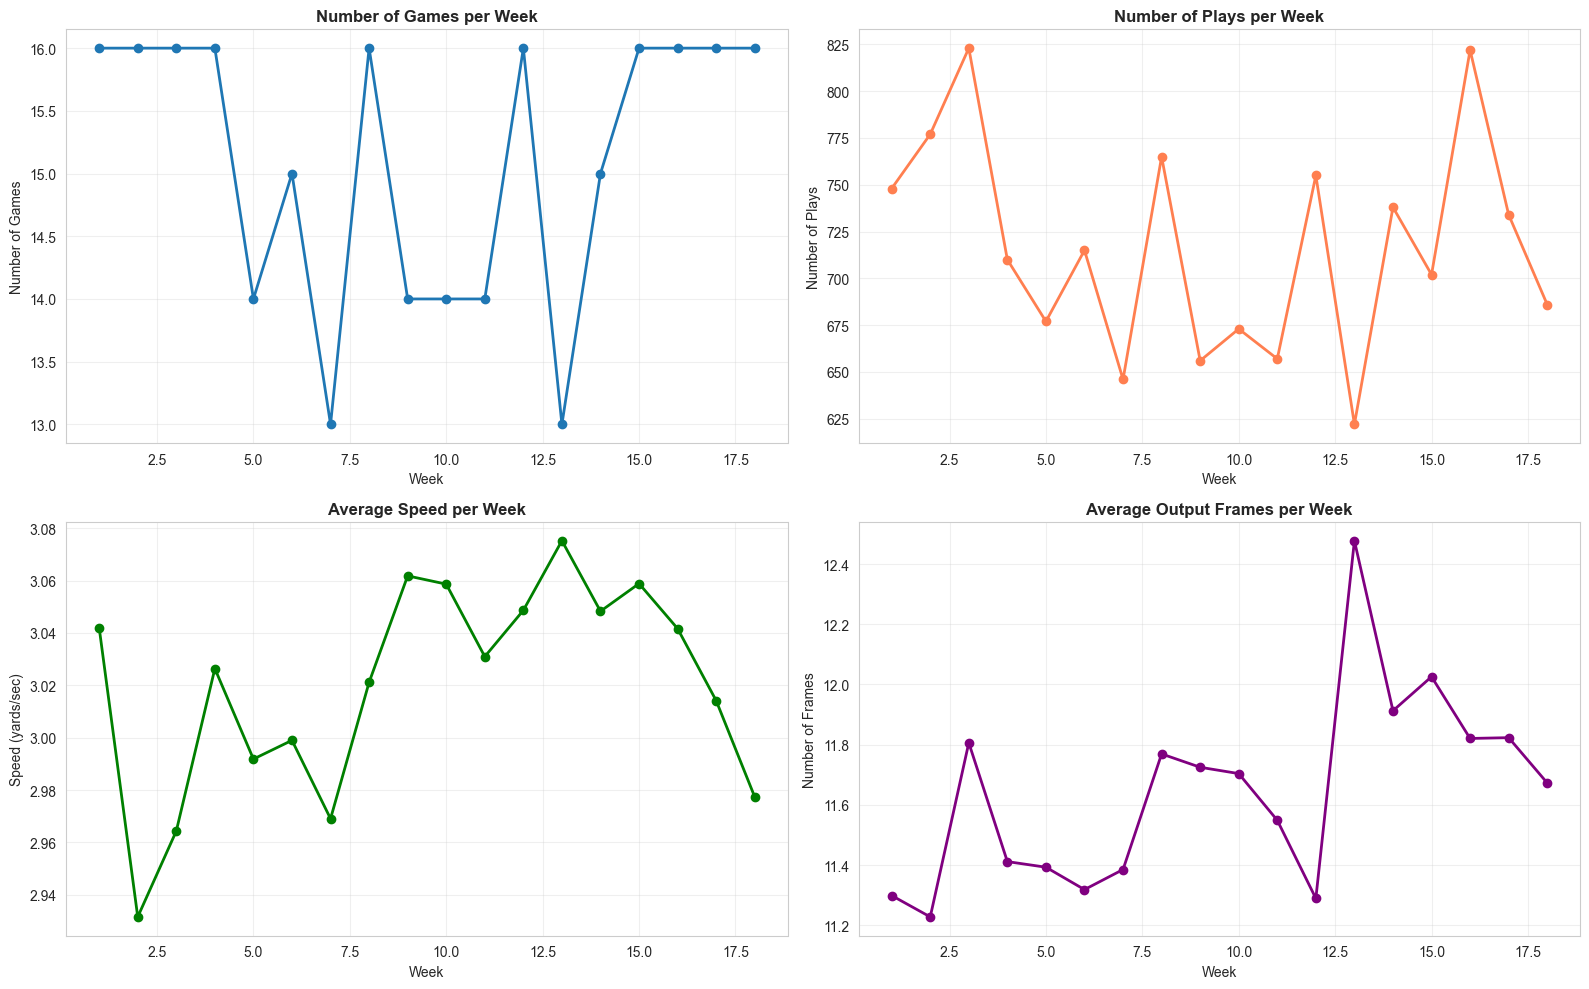

In [24]:
# Analyze trends over weeks
weekly_stats = df_input.groupby('week').agg({
    'game_id': 'nunique',
    'play_id': 'nunique',
    's': 'mean',
    'a': 'mean',
    'num_frames_output': 'mean'
}).rename(columns={'game_id': 'num_games', 'play_id': 'num_plays'})

print("WEEKLY STATISTICS:")
print(weekly_stats)

eda_results['temporal_patterns'] = {'weekly_stats': weekly_stats.to_dict()}

# Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].plot(weekly_stats.index, weekly_stats['num_games'], marker='o', linewidth=2)
axes[0, 0].set_title('Number of Games per Week', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Week')
axes[0, 0].set_ylabel('Number of Games')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(weekly_stats.index, weekly_stats['num_plays'], marker='o', linewidth=2, color='coral')
axes[0, 1].set_title('Number of Plays per Week', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Week')
axes[0, 1].set_ylabel('Number of Plays')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(weekly_stats.index, weekly_stats['s'], marker='o', linewidth=2, color='green')
axes[1, 0].set_title('Average Speed per Week', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Week')
axes[1, 0].set_ylabel('Speed (yards/sec)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(weekly_stats.index, weekly_stats['num_frames_output'], marker='o', linewidth=2, color='purple')
axes[1, 1].set_title('Average Output Frames per Week', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Week')
axes[1, 1].set_ylabel('Number of Frames')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_outputs/plots/12_temporal_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Player Physical Attributes

In [25]:
# Analyze player height and weight
unique_players = df_input.groupby('nfl_id').first()

print("PLAYER PHYSICAL ATTRIBUTES:")
print(unique_players[['player_height', 'player_weight']].describe())

eda_results['player_analysis']['physical_attributes'] = {
    'height_stats': unique_players['player_height'].describe().to_dict(),
    'weight_stats': unique_players['player_weight'].dropna().describe().to_dict()
}

# Age calculation (if birth date available)
if 'player_birth_date' in unique_players.columns:
    unique_players['player_birth_date'] = pd.to_datetime(unique_players['player_birth_date'], errors='coerce')
    unique_players['age'] = (pd.Timestamp('2023-09-01') - unique_players['player_birth_date']).dt.days / 365.25
    print("\nPLAYER AGE DISTRIBUTION:")
    print(unique_players['age'].describe())
    eda_results['player_analysis']['age_stats'] = unique_players['age'].describe().to_dict()

PLAYER PHYSICAL ATTRIBUTES:
       player_weight
count    1384.000000
mean      223.888728
std        33.223632
min       153.000000
25%       200.000000
50%       215.000000
75%       245.000000
max       358.000000

PLAYER AGE DISTRIBUTION:
count    1384.000000
mean       26.379299
std         2.946641
min        20.906229
25%        24.243669
50%        25.875428
75%        28.119781
max        39.285421
Name: age, dtype: float64


## 13. Target Analysis - Distance to Ball

INITIAL DISTANCE TO BALL LANDING:
count    173150.000000
mean         18.992941
std          10.579340
min           0.050990
25%          10.872785
50%          17.377908
75%          25.585270
max          71.196437
Name: distance_to_ball, dtype: float64

DISTANCE TO BALL BY ROLE:
                        count       mean        std       min        25%  \
player_role                                                                
Defensive Coverage  2662657.0  18.886018  10.238920  0.010002  10.913043   
Other Route Runner  1424243.0  21.462570  11.438038  0.036053  12.714491   
Passer               396765.0  22.029878  10.518127  0.240208  14.206283   
Targeted Receiver    396914.0  13.064076   8.797637  0.019999   6.778008   

                          50%        75%        max  
player_role                                          
Defensive Coverage  17.432902  25.589853  66.888114  
Other Route Runner  20.158880  28.902904  71.713086  
Passer              19.765555  27.528051  7

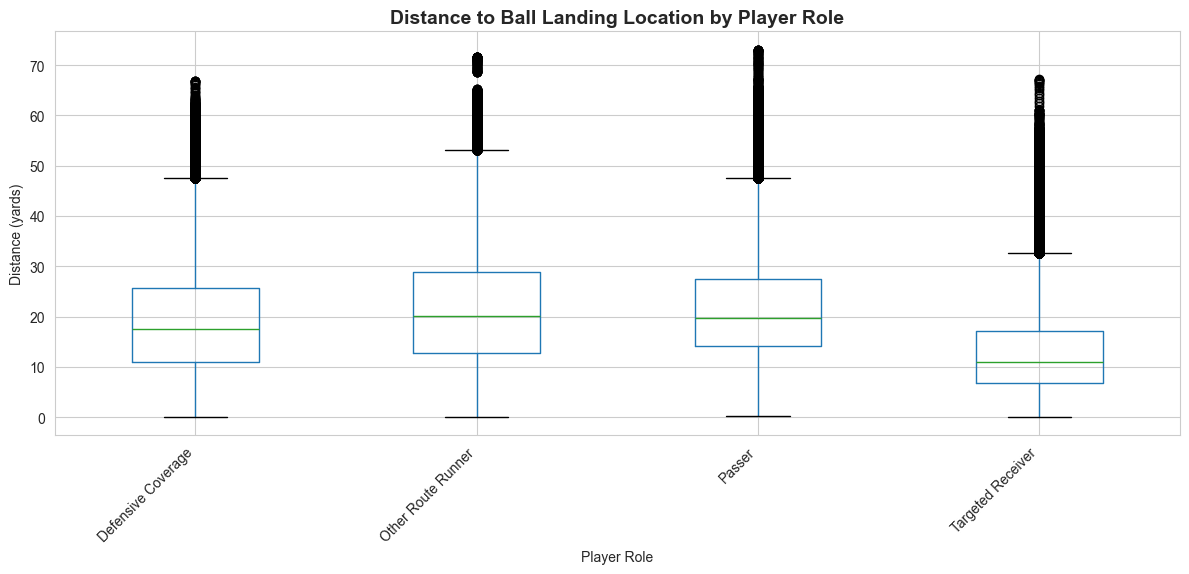

In [26]:
# Calculate distance from player to ball landing location
df_input['distance_to_ball'] = np.sqrt(
    (df_input['x'] - df_input['ball_land_x'])**2 + 
    (df_input['y'] - df_input['ball_land_y'])**2
)

# Get initial distance (first frame) for each player
initial_distance = df_input.groupby(['game_id', 'play_id', 'nfl_id'])['distance_to_ball'].first()

print("INITIAL DISTANCE TO BALL LANDING:")
print(initial_distance.describe())

# By role
df_input_with_role = df_input.merge(
    df_input.groupby(['game_id', 'play_id', 'nfl_id'])['player_role'].first().reset_index(),
    on=['game_id', 'play_id', 'nfl_id'],
    suffixes=('', '_role')
)

distance_by_role = df_input.groupby('player_role')['distance_to_ball'].describe()
print("\nDISTANCE TO BALL BY ROLE:")
print(distance_by_role)

eda_results['ball_trajectory']['distance_to_ball_stats'] = initial_distance.describe().to_dict()
eda_results['ball_trajectory']['distance_by_role'] = distance_by_role.to_dict()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
df_input.boxplot(column='distance_to_ball', by='player_role', ax=ax)
ax.set_title('Distance to Ball Landing Location by Player Role', fontsize=14, fontweight='bold')
ax.set_xlabel('Player Role')
ax.set_ylabel('Distance (yards)')
ax.get_figure().suptitle('')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.savefig('eda_outputs/plots/13_distance_to_ball_by_role.png', dpi=150, bbox_inches='tight')
plt.show()

## 14. Data Summary & Key Insights

In [27]:
# Generate summary insights
summary_insights = {
    'dataset_overview': {
        'total_input_records': int(len(df_input)),
        'total_output_records': int(len(df_output)),
        'unique_games': int(unique_games),
        'unique_plays': int(unique_plays),
        'unique_players': int(unique_players),
        'weeks_covered': len(input_files)
    },
    'key_statistics': {
        'avg_players_per_play': float(players_per_play.mean()),
        'avg_input_frames': float(input_frames_per_play.mean()),
        'avg_output_frames': float(output_frames.mean()),
        'avg_ball_time_in_air_sec': float(time_in_air.mean()),
        'avg_speed_yards_per_sec': float(df_input['s'].mean()),
        'avg_acceleration': float(df_input['a'].mean()),
        'avg_pass_distance_yards': float(play_info['pass_distance'].mean())
    },
    'prediction_task': {
        'records_to_predict': int(df_input['player_to_predict'].sum()),
        'avg_frames_to_predict_per_player': float(output_frames.mean()),
        'avg_displacement_per_frame': float(transition['displacement'].mean()),
        'avg_total_displacement': float(total_movement['total_displacement'].mean())
    }
}

eda_results['summary'] = summary_insights

print("="*80)
print("KEY INSIGHTS SUMMARY")
print("="*80)
print(json.dumps(summary_insights, indent=2))

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'DataFrame'

## 15. Save Results to JSON

In [ ]:
# Save complete EDA results
output_file = 'eda_outputs/eda_results.json'

with open(output_file, 'w') as f:
    json.dump(eda_results, f, indent=2)

print(f"EDA results saved to: {output_file}")
print(f"Total plots saved: {len(list(Path('eda_outputs/plots').glob('*.png')))}")
print(f"\nFile size: {Path(output_file).stat().st_size / 1024:.2f} KB")
print("\n" + "="*80)
print("EDA COMPLETE!")
print("="*80)
print(f"\nCompleted at: {datetime.now()}")

## 16. Additional Visualizations - Trajectory Examples

In [ ]:
# Visualize actual trajectories for a few sample players
sample_play_ids = df_output.groupby(['game_id', 'play_id']).size().sample(3, random_state=42).index

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for idx, (game_id, play_id) in enumerate(sample_play_ids):
    # Get output trajectory for this play
    play_output = df_output[(df_output['game_id'] == game_id) & (df_output['play_id'] == play_id)]
    play_input = df_input[(df_input['game_id'] == game_id) & (df_input['play_id'] == play_id)]
    
    # Get ball landing
    ball_x = play_input['ball_land_x'].iloc[0]
    ball_y = play_input['ball_land_y'].iloc[0]
    
    # Plot trajectories for each player
    for nfl_id in play_output['nfl_id'].unique()[:10]:  # Limit to 10 players for clarity
        player_traj = play_output[play_output['nfl_id'] == nfl_id].sort_values('frame_id')
        player_info = play_input[play_input['nfl_id'] == nfl_id].iloc[0]
        
        color = 'blue' if player_info['player_side'] == 'Offense' else 'red'
        alpha = 0.8 if player_info['player_role'] == 'Targeted Receiver' else 0.4
        linewidth = 3 if player_info['player_role'] == 'Targeted Receiver' else 1.5
        
        axes[idx].plot(player_traj['x'], player_traj['y'], 
                      color=color, alpha=alpha, linewidth=linewidth, marker='o', markersize=3)
        
        # Mark start and end
        axes[idx].scatter(player_traj['x'].iloc[0], player_traj['y'].iloc[0], 
                         color=color, s=100, marker='o', edgecolors='black', zorder=5)
        axes[idx].scatter(player_traj['x'].iloc[-1], player_traj['y'].iloc[-1], 
                         color=color, s=100, marker='s', edgecolors='black', zorder=5)
    
    # Plot ball landing
    axes[idx].scatter(ball_x, ball_y, c='green', s=400, marker='X', 
                     edgecolors='black', linewidths=3, label='Ball Landing', zorder=10)
    
    axes[idx].set_xlim(0, 120)
    axes[idx].set_ylim(0, 53.3)
    axes[idx].set_aspect('equal')
    axes[idx].set_title(f'Player Trajectories\nGame: {game_id}, Play: {play_id}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('X (yards)')
    if idx == 0:
        axes[idx].set_ylabel('Y (yards)')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend(['Ball Landing'], loc='upper right')

plt.suptitle('Sample Player Trajectories During Ball Flight', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('eda_outputs/plots/14_sample_trajectories.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTrajectory visualization complete!")

In [ ]:
print("\n" + "="*80)
print("COMPREHENSIVE EDA COMPLETE")
print("="*80)
print(f"\nOutputs saved to:")
print(f"  - JSON: eda_outputs/eda_results.json")
print(f"  - Plots: eda_outputs/plots/ ({len(list(Path('eda_outputs/plots').glob('*.png')))} images)")
print(f"\nAnalysis completed at: {datetime.now()}")